---
title: 'thank u, Nest (고객평생가치 기반 고객세분화 분석)'
date: '2024-02-25'
categories: ⭐
---

## 사전 준비 코드

### 라이브러리 호출 및 한글 출력 관련 설정

---



---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Colab에서 한글 폰트 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq -y # -y 플래그를 추가하여 자동 yes 응답

# 설치된 나눔스퀘어 ac 폰트 경로 찾기
font_files = !fc-list :lang=ko | grep "NanumGothicCoding"

# 찾은 폰트 경로를 사용
if font_files:
    # 첫 번째 찾은 경로를 사용
    font_path = font_files[0].split(':')[0]
    print(f"Found font path: {font_path}")

    import matplotlib.font_manager as fm

    fm.fontManager.addfont(font_path)

    plt.rc('font', family='NanumGothicCoding')
    sns.set_theme(font="NanumGothicCoding")

    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
else:
    print("NanumGothicCoding font not found after installation. Please check installation.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Found font path: /usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf


## 고객평생가치 기반 세분화 분석

### 배경

모든 고객은 동일한 가치를 지니지 않습니다. Fader의 저서에서 언급된 '모든 손님은 왕이다'라는 전통적인 접근 방식은 모든 고객을 동등하게 대우하려는 경향을 보입니다. 하지만 고객 평생 가치(Customer Lifetime Value, CLV) 관점에서 보면, 모든 고객이 비즈니스에 동일한 기여를 하는 것은 아닙니다. 성공적인 비즈니스를 위해서는 한정된 자원을 보다 잠재 가치가 높은 고객에게 집중하고, 이들을 중심으로 비즈니스 전략을 전개하는 고객 중심(Customer Centricity) 경영이 필수적입니다. 고객 중심 경영은 마케팅 활동을 측정 가능한 지표로 전환하며, 고객 관계 관리(Customer Relationship Management, CRM) 시스템을 통해 확보된 고객 데이터를 기반으로 고객을 깊이 이해하고, 이를 통해 궁극적으로 기업 이익을 극대화하는 것을 목표로 합니다.

단순히 고객 정보를 기록하는 것만으로는 충분하지 않습니다. CRM의 진정한 가치는 기록된 정보를 적극적으로 활용하여 고객 개개인에 대한 이해를 높이고, 이를 바탕으로 맞춤형 전략을 수립하는 데 있습니다.

이러한 고객 평생 가치 접근법은 고객을 정량적으로 이해하고, 그 결과를 실제 마케팅 전략에 적용하려는 시도입니다. 마침 이러한 분석을 실제 데이터를 활용해 실습해 볼 기회를 찾던 중, 본 공모전을 알게 되어 참여하게 되었습니다.



### 데이터 설명

분석에 사용된 데이터는 다음과 같습니다.

- 온라인 거래 관련 데이터 (Sales Data)

- 고객 정보 데이터 (Customer Data)

- 할인 정보 데이터 (Discount Data)

- 마케팅 비용 정보 데이터 (Marketing Cost Data)

- 세금 관련 정보 데이터 (Tax Data)


### 데이터 전처리

#### 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 데이터를 저장한 Google Drive 경로로 수정
data_path = '/content/drive/MyDrive/700. 프로젝트/740. 데이터분석/02. thank-u-nest/01. data/'

customer = pd.read_csv(data_path + 'Customer_info.csv')
discount = pd.read_csv(data_path + 'Discount_info.csv')
marketing = pd.read_csv(data_path + 'Marketing_info.csv')
onlinesales = pd.read_csv(data_path + 'Onlinesales_info.csv')
tax = pd.read_csv(data_path + 'Tax_info.csv')

Mounted at /content/drive


#### 날짜 전처리

In [ ]:
month_dict = {
  'Jan': 1,
  'Feb': 2,
  'Mar': 3,
  'Apr': 4,
  'May': 5,
  'Jun': 6,
  'Jul': 7,
  'Aug': 8,
  'Sep': 9,
  'Oct': 10,
  'Nov': 11,
  'Dec': 12
}

In [ ]:
discount['월'] = discount.월.replace(month_dict)

/tmp/ipython-input-4-3398978212.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  discount['월'] = discount.월.replace(month_dict)


In [ ]:
marketing['날짜'] = pd.to_datetime(marketing['날짜'], format='%Y-%m-%d')

In [ ]:
onlinesales['거래날짜'] = pd.to_datetime(onlinesales['거래날짜'], format='%Y-%m-%d')

In [ ]:
# 연, 월, 일 추출
onlinesales['연'] = onlinesales['거래날짜'].dt.year
onlinesales['월'] = onlinesales['거래날짜'].dt.month
onlinesales['일'] = onlinesales['거래날짜'].dt.day

#### 고객의 실구매금액 계산

- 세전가격 = (평균비용 * 수량) * (1-할인율)
- 세후가격(실구매금액) = 세전가격*(1+세율)

In [ ]:
sales = (onlinesales
 .merge(customer, on='고객ID', how='left')
 .merge(tax, on='제품카테고리', how='left')
 .merge(marketing, left_on='거래날짜', right_on='날짜', how='left')
 .merge(discount, on=['월','제품카테고리'], how='left')
)

sales['세전가격'] = np.where(sales.쿠폰상태 == 'Used',
                         (sales.평균금액 * sales.수량) * (1-(1/100 * sales.할인율)) + sales.배송료,
                         (sales.평균금액 * sales.수량) + sales.배송료
                        )
sales['세후가격'] = sales.세전가격*(1+sales.GST)


### 데이터 탐색

이 중 주요 분석 대상인 온라인 거래(Sales) 데이터 내 제품 카테고리별 판매 수량 및 판매 금액을 분석한 결과는 다음과 같습니다.


In [ ]:
t3 = sales.loc[:, ['제품카테고리', '수량', '세후가격']].groupby('제품카테고리').sum()
t3 = pd.concat([t3, t3 / t3.sum()], axis=1)
t3.columns = ['판매수량', '판매금액', '판매수량_비율', '판매금액_비율']
t3.reset_index(inplace=True)

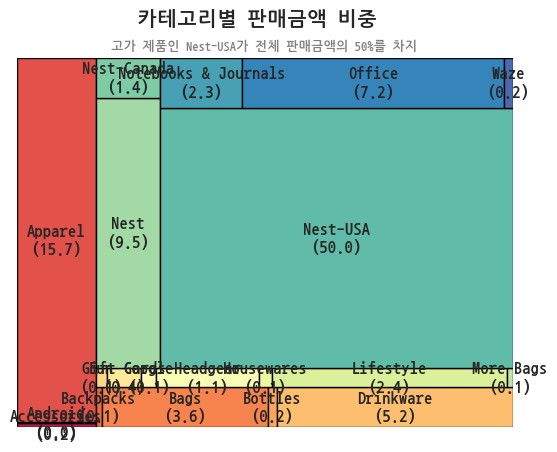

In [ ]:
!pip install squarify
import squarify

label = t3.제품카테고리 + '\n(' + round(t3.판매금액_비율*100, 1).astype(str) + ')'
squarify.plot(t3.판매금액_비율, label=label, ec = 'black',
              color = sns.color_palette("Spectral", len(t3)))
plt.axis("off")
plt.suptitle('카테고리별 판매금액 비중')
plt.title('고가 제품인 Nest-USA가 전체 판매금액의 50%를 차지',fontsize=9, color='gray')
plt.show()


판매 금액 비중에서는 Nest 계열(Nest-USA, Nest, Nest-Canada) 제품이 과반수를 차지하는 것으로 나타났습니다. 반면, 판매 수량 비중에서는 Office, Apparel, Drinkware 등의 카테고리가 높은 비중을 차지했습니다. 이는 Nest 계열 제품이 상대적으로 고가이며 구매 주기가 긴 반면, Office, Apparel, Drinkware 등의 카테고리는 비교적 저렴하고 구매 빈도가 높은 품목이기 때문으로 해석됩니다. 이러한 상품 특성의 차이는 고객 분석 시 반드시 고려되어야 할 중요한 요소입니다.


### 데이터 분석

분석은 두 Phase로 나뉘어 진행됩니다. 첫번째 페이즈에서는 RFM/P 분석을 수행합니다. 두번째 페이즈에서는 RFM/P 수치를 기반으로 고객평생가치를 구합니다.

RFM 분석은 최근구매 (Recency), 구매주기(Frequency)와 금전가치(Monetary Value)를 산출하여 고객을 세분화하는 방법입니다. RFP 분석은 카테고리의 차이를 고려하지 않고 최근구매 (Recency), 구매주기(Frequency)와 금전가치(Monetary Value)를 산출하여 RFM 분석을 수행하면 오류를 일으킬 수 있습니다.

이에 따라 카테고리를 고려한 RFM 분석, 즉 RFM/P (Recency, Frequency, Monetary Value per Product category) 분석을 수행하였습니다.

RFM 분석과 같은 고객 세분화를 시도하는 것은 가치 있는 고객을 알아보기 위함입니다. 고객의 가치를 파악하기 위해 RFM 지표로부터 $t$ 시점까지 고객 $i$ 의 카테고리 $j$ 에 대한 예상구매금액과 예상구매횟수를 구했으며, 이는 각각 Gamma-Gamma 모델과 BG/NBD 모델로부터 추정되었습니다.

이 글에서는 미래 52주(t=52)에 대한 모든 유저의 ‘More Bags’, ‘Android’를 제외한 카테고리에 대한 예상구매금액과 예상구매횟수를 구했습니다.
$$고객가치_{ij} = 예상구매금액_{ij} ×예상구매횟수_{ij}$$
추정된 예상구매금액과 예상구매횟수의 곱이 고객/카테고리별 고객가치이며, 이로부터 아래와 같은 고객/제품 평생가치 포트폴리오를 구축할 수 있습니다. 포트폴리오 내 고객/카테고리별 가치를 고객별로 합산한 값이 고객평생가치입니다.

#### 고객별 RFM/P(Recency, Frequency, Monetary value per Product category) 계산

In [ ]:
Recency = (sales
.groupby(['고객ID', '제품카테고리'])['거래날짜']
.max()
.transform(lambda x: pd.to_datetime('2019-12-31') - x)
.rename('Recency')
.to_frame()
.reset_index()
)

In [ ]:
Duration = (sales
.groupby(['고객ID', '제품카테고리'])['거래날짜']
.min()
.transform(lambda x: pd.to_datetime('2019-12-31') - x)
.rename('Duration')
.to_frame()
.reset_index()
)

In [ ]:
Frequency = (sales
 .loc[:, ['고객ID', '제품카테고리', '거래날짜']]
 .groupby(['고객ID', '제품카테고리', '거래날짜'])
 .head(1)
 .groupby(['고객ID', '제품카테고리'])
 .count()
 .loc[:,'거래날짜']
 .to_frame()
 .rename({'거래날짜':'Frequency'}, axis=1)
 .reset_index()
 .assign(Frequency = lambda x: x.Frequency - 1)
)

In [ ]:
Monetary = (sales
 .loc[:,['고객ID','제품카테고리', '세후가격']]
 .groupby(['고객ID', '제품카테고리'])
 .sum()
 .rename({'세후가격':'Monetary'}, axis=1)
 .reset_index()
)

In [ ]:
RFM = pd.merge(Recency, Frequency, on=['고객ID', '제품카테고리'])
RFM = pd.merge(RFM, Duration, on=['고객ID', '제품카테고리'])
RFM = pd.merge(RFM, Monetary, on=['고객ID', '제품카테고리'])

In [ ]:
RFM['Monetary'] = RFM['Monetary'] / (RFM['Frequency']+1)
RFM['Recency'] = RFM.Recency.dt.days
RFM['Duration'] = RFM.Duration.dt.days

In [ ]:
RFM['Recency'] = np.where(RFM['Recency'] == RFM['Duration'], 0, RFM['Recency'])
RFM['Recency'] = RFM['Recency'] / 7
RFM['Duration'] = RFM['Duration'] / 7
RFM['Frequency'] = RFM['Frequency'].astype(float)

#### BG/NBD 모델 (예상구매횟수)

In [ ]:
from scipy.special import gammaln

def negative_log_likelihood(params, x, t_x, T):
    if np.any(np.asarray(params) <= 0):
        return np.inf

    r, alpha, a, b = params

    ln_A_1 = gammaln(r+x) - gammaln(r) + r*np.log(alpha + 1e-6)
    ln_A_2 = (gammaln(a+b) + gammaln(b+x) - gammaln(b) - gammaln(a+b+x))
    ln_A_3 = -(r+x) * np.log(alpha+T+1e-6)
    ln_A_4 = x.copy()
    ln_A_4[ln_A_4 > 0] = (
        np.log(a+ 1e-6) -
        np.log(b + ln_A_4[ln_A_4 > 0] - 1 + 1e-6) -
        (r+ln_A_4[ln_A_4 > 0]) * np.log(alpha+t_x+ 1e-6)
    )

    delta = np.where(x>0, 1, 0)

    log_likelihood = ln_A_1 + ln_A_2 + np.log(np.exp(ln_A_3) + delta * np.exp(ln_A_4) + 1e-6)

    return -log_likelihood.sum()

In [ ]:
def calculate_conditional_expectation(t, x, t_x, T):
    first_term = (a+b+x-1) / (a-1)
    hyp2f1_a = r+x
    hyp2f1_b = b+x
    hyp2f1_c = a + b + x - 1
    hyp2f1_z = t / (alpha + T + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    second_term = (1 - ((alpha+T) / (alpha+T+t))**(r+x) * hyp_term)
    delta = np.where(x > 0, 1, 0)
    denominator = 1 + delta * (a/(b+x-1)) * ((alpha+T) / (alpha+t_x))**(r+x)

    return first_term * second_term / denominator

In [ ]:
def _func_caller(params, func_args, function):
    return function(params, *func_args)

In [ ]:
from scipy.optimize import minimize

def fit_bgf(grouped):

    scale = 1 / grouped['Duration'].max()
    scaled_recency = grouped['Recency'] * scale
    scaled_T = grouped['Duration'] * scale

    current_init_params = np.ones(4)

    output = minimize(
        _func_caller,
        method='Nelder-Mead',
        tol=0.0001,
        x0=current_init_params,
        args=([grouped['Frequency'], scaled_recency, scaled_T], negative_log_likelihood),
        options={'maxiter':2000}
    )

    r = output.x[0]
    alpha = output.x[1]
    a = output.x[2]
    b = output.x[3]

    alpha /= scale

    print("r = {}".format(r))
    print("alpha = {}".format(alpha))
    print("a = {}".format(a))
    print("b = {}".format(b))

    return r, alpha, a, b

#### Gamma-Gamma 모델 (예상구매금액)

In [ ]:
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import invgamma

def negative_log_likelihood_ggf(params, x, bar_z):
    if np.any(np.asarray(params) <= 0):
        return np.inf

    p, q, gamma = params

    log_likelihood = np.where(x == 0, 0, gammaln(p*x + q) - gammaln(p*x) - gammaln(q) + q*np.log(gamma + 1e-6) + (p*x-1)*np.log(bar_z + 1e-6) + p*x*np.log(x + 1e-6)  - (p*x+q)*np.log(gamma + x*bar_z + 1e-6))

    return -log_likelihood.sum()

def fit_ggf(grouped):

    current_init_params = np.ones(3)

    output = minimize(
        _func_caller,
        method='Nelder-Mead',
        tol=0.0001,
        x0=current_init_params,
        args=([grouped['Frequency'], grouped['Monetary']], negative_log_likelihood_ggf),
        options={'maxiter':2000}
    )

    p = output.x[0]
    q = output.x[1]
    gamma = output.x[2]

    print("p = {}".format(p))
    print("q = {}".format(q))
    print("gamma = {}".format(gamma))

    return p, q, gamma

def calculate_conditional_expectation_ggf(x, z_bar):

    # q가 1보다 작은 경우 알려진 mean이 없음
    if q < 1:
        z = [np.mean(invgamma.rvs(q, scale=p*gamma, size=100)) for i in range(100)]
        expectation_z = np.mean(z)
        weight = (q-1)/(p*x+q-1)

    elif q == 1:
        expectation_z = 0
        weight = 0

    else:
        expectation_z = p*gamma/(q-1)
        weight = (q-1)/(p*x+q-1)

    return weight*expectation_z + (1-weight)*z_bar

#### 고객평생가치 계산

In [ ]:
df = pd.DataFrame(columns=['고객ID', '제품카테고리', 'Recency', 'Frequency',
                      'Duration', 'Monetary','predicted_purchases', 'expected_average_profit'])
t = 52

for category, grouped in RFM.groupby('제품카테고리'):

    if (category == 'More Bags') | (category == 'Android'):
        continue

    print(category)
    print('----------------------')

    r, alpha, a, b = fit_bgf(grouped)
    grouped['predicted_purchases'] = calculate_conditional_expectation(t,
                                                                 grouped['Frequency'],
                                                                 grouped['Recency'],
                                                                 grouped['Duration'])

    p, q, gamma = fit_ggf(grouped)

    grouped['expected_average_profit'] = calculate_conditional_expectation_ggf(grouped['Frequency'], grouped['Monetary'])

    df = pd.concat([df, grouped], ignore_index=True)

Accessories
----------------------
r = 0.13912008073722326
alpha = 8.176630570812936
a = 1052808.6234128857
b = 501402.9633816013
p = 1.8348050677519895e+133
q = 3.5580081632721924e+127
gamma = 4.6042778608761196e-05
Apparel
----------------------


/tmp/ipykernel_226/806044944.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, grouped], ignore_index=True)


r = 0.17923159086008145
alpha = 1.1903404140925717
a = 12.696467541252009
b = 27.601082880439954
p = 2.5129593127494996
q = 2.6069465924123243
gamma = 208.15006556477317
Backpacks
----------------------
r = 0.26646419623447243
alpha = 116.52392596923818
a = 9.394653723311084e-10
b = 2.2672142445478647
p = 3.727981318000165e+89
q = 2.5337574645747155e+84
gamma = 0.0005354572432201953
Bags
----------------------
r = 0.1268609869185903
alpha = 2.966232640652436
a = 7.316117332170791
b = 12.390568106079222
p = 3.4224680850941467
q = 2.77620821431516
gamma = 93.17829522329001
Bottles
----------------------
r = 0.32202021881812226
alpha = 58.88183726710254
a = 7.542067151205418e-08
b = 1.7094503770590088
p = 2.743222204193875e+64
q = 1.4604030300902113e+58
gamma = 7.526130258503049e-06
Drinkware
----------------------
r = 0.15220915102007612
alpha = 2.6623905053523713
a = 5.545536572500552
b = 9.173539222442841
p = 2.090490964871371
q = 2.4401314642392835
gamma = 139.90068112083412
Fun
-----

In [ ]:
df['CLV'] = df['predicted_purchases'] * df['expected_average_profit']

In [ ]:
table = df.pivot(index='고객ID',columns='제품카테고리', values='CLV').fillna(0)

In [ ]:
groups = pd.qcut(table.sum(axis=1), q=10, labels=np.arange(10)+1).rename('Group')


### 분석결과


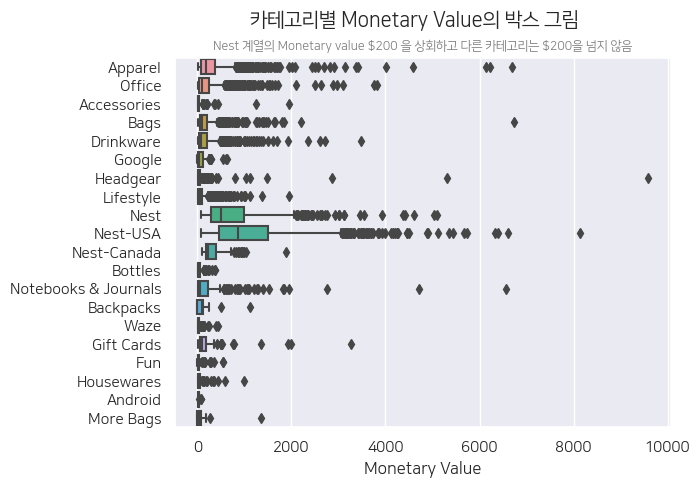

In [ ]:
import seaborn as sns

# 카테고리별 박스플롯
sns.boxplot(x='Monetary', y='제품카테고리', orient='h', data=RFM)

plt.xlabel('Monetary Value')
plt.ylabel('')
plt.suptitle('카테고리별 Monetary Value의 박스 그림')
plt.title('Nest 계열의 Monetary value \$200 을 상회하고 다른 카테고리는 \$200을 넘지 않음',fontsize=9, color='gray')
plt.show()

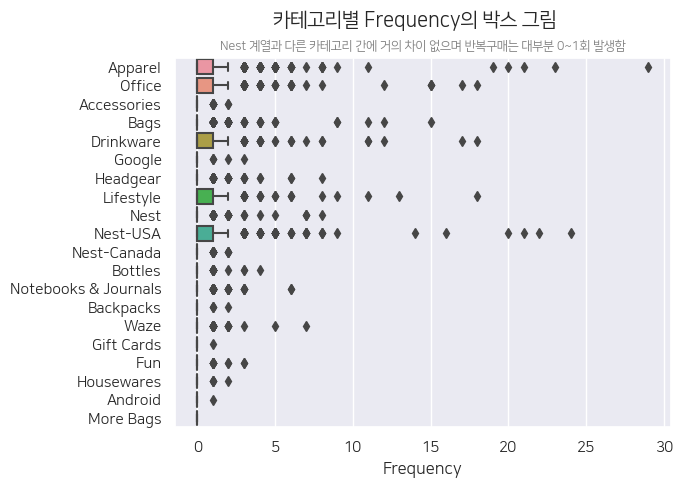

In [ ]:
import seaborn as sns

# 카테고리별 박스플롯
sns.boxplot(x='Frequency', y='제품카테고리', orient='h', data=RFM)

plt.suptitle('카테고리별 Frequency의 박스 그림')
plt.title('Nest 계열과 다른 카테고리 간에 거의 차이 없으며 반복구매는 대부분 0~1회 발생함',fontsize=9, color='gray')
plt.ylabel('')
plt.show()

Monetary Value는 Nest 계열의 값이 평균적으로 컸습니다. 이는 Nest 계열 제품의 상품가격이 비싸기 때문에 나타나는 현상으로 보입니다. 하지만, Frequency에 있어서는 Nest와 다른 카테고리 사이의 차이가 거의 없었습니다. 분석 초기에 예상한 것처럼 Nest 계열의 Monetary Value는 다른 카테고리보다 컸지만, 예상과 달리 다른 카테고리의 Frequency가 크지 않았고, 오히려 Nest 계열의 상품에서도 반복구매(Frequency가 0보다 큼)가 타 카테고리만큼 작았습니다.

Text(0.5, 1.0, '10분위 \\$2,926 1분위는 \\$92 로 크게 차이남')

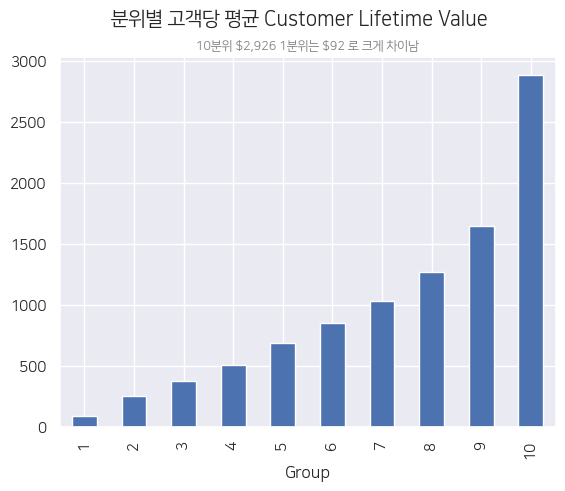

In [ ]:
(t7.sum(axis=1) / groups.value_counts()).plot.bar()
plt.suptitle('분위별 고객당 평균 Customer Lifetime Value')
plt.title('10분위 \$2,926 1분위는 \$92 로 크게 차이남',fontsize=9, color='gray')

분위별 고객 평균 고객평생가치는 위와 같이 비선형적으로 증가합니다. 가장 고객평생가치가 큰 그룹인 10 그룹은 \$2,926/1년, 가장 낮은 1 그룹은 \$92/1년 정도의 추정가치를 보입니다.

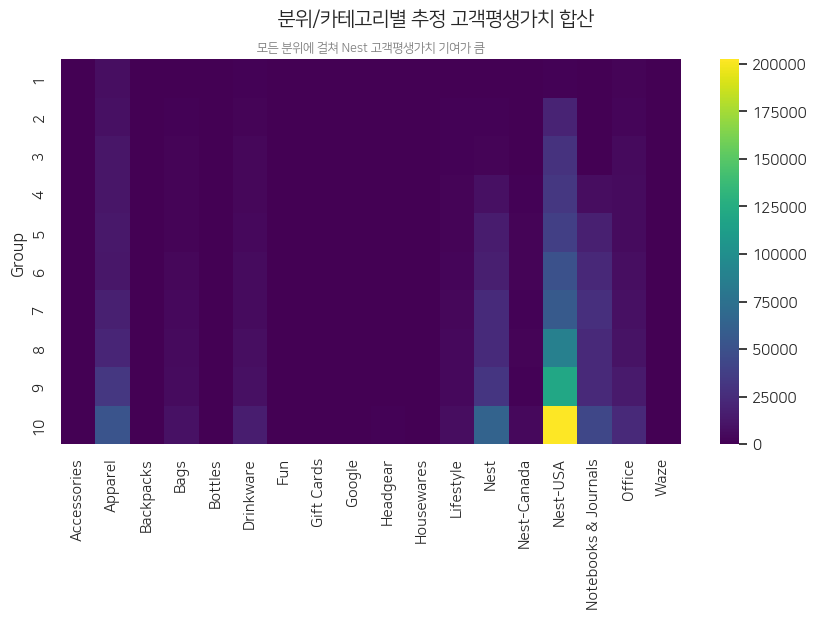

In [ ]:
t7 = table.join(groups).groupby('Group', observed=False).sum()
cmap = "viridis"
plt.figure(figsize=(10, 5))
sns.heatmap(t7, cmap=cmap)
plt.suptitle('분위/카테고리별 추정 고객평생가치 합산')
plt.title('모든 분위에 걸쳐 Nest 고객평생가치 기여가 큼',fontsize=9, color='gray')
# plt.show()
plt.savefig('plot.png', bbox_inches="tight")

그림에서 볼 수 있듯이, 모든 분위에서 Nest가 추정 고객평생가치에 기여하는 바가 큽니다. 이는 마케팅 프로모션 비용의 대부분을 Nest 카테고리에 집중해야 함을 시사합니다.

In [ ]:
t8 = t7.apply(lambda col: col / t7.sum(axis=1), axis=0)

In [ ]:
other_cols = table.sum(axis=0).sort_values()[:10].index.values

In [ ]:
main_cols = [col for col in t8.columns.values if col not in other_cols]

In [ ]:
t8['Others'] = t8[other_cols].sum(axis=1)
t8 = t8[np.append(main_cols, 'Others')]

Text(0.5, 1.0, '분위가 높아질수록 Nest, Nest-USA가 차지하는 비중이 커짐')

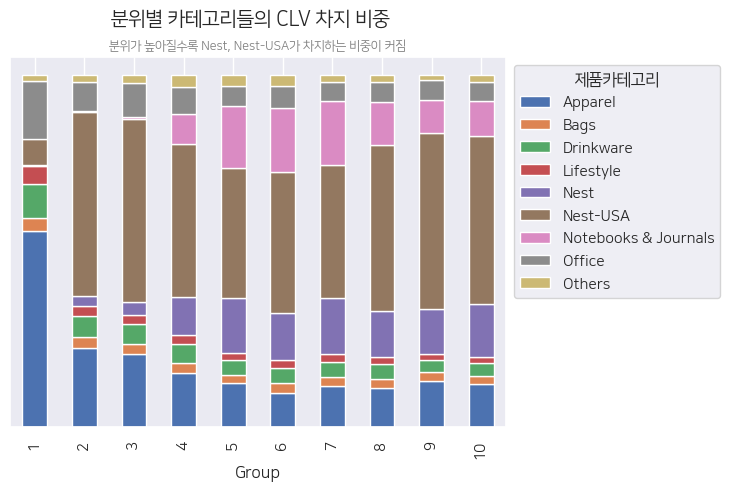

In [ ]:
t8.plot.bar(stacked=True)

plt.legend(title="제품카테고리", bbox_to_anchor = (1,1))
plt.yticks([])
plt.suptitle('분위별 카테고리들의 CLV 차지 비중')
plt.title('분위가 높아질수록 Nest, Nest-USA가 차지하는 비중이 커짐',fontsize=9, color='gray')

분위 내 카테고리의 고객평생가치 차지 비중을 확인하면, 추정 고객평생가치가 큰 10 그룹으로 갈수록 Nest 계열 제품의 비중이 평생가치 합산에서 차지하는 비중이 커지는 것을 확인할 수 있습니다. 이는 Nest 카테고리가 아닌 카테고리의 구매를 Nest 카테고리의 구매로 연결시키는 것이 더 많은 이익을 창출하기 위한 방법임을 알려줍니다.

### 인사이트 및 솔루션 제안




#### Nest 카테고리 강화 및 다른 카테고리로 고객 중심성 재편

① 마케팅 프로모션 비용의 60% 이상을 Nest에 활동

Nest 계열(Nest, Nest-Canada, Nest-USA)이 고객평생가치에 차지하는 비중이 60% 이상입니다. 이에 추후 예상 마케팅 투자는 Nest 계열에 60% 이상 투자하는 것이 옳습니다. 위에서 확인했듯이 높은 고객평생가치를 지닌 그룹에서의 Nest 구매 비중은 더욱 커지므로 마케팅 비용의 70~80%를 Nest 제품에 할애하는 것이 바람직합니다.

② Nest 케이스 및 액세서리 제품 도입

Nest는 Google의 센서 기반 제품 라인업으로, 전자기기의 경우 외부 충격 방지나 개인화를 위해 케이스 제품이 선호됩니다. Nest 소유 고객은 스토어에 가장 큰 고객이라고 할 수 있으므로 그로부터 추가 이익을 획득할 수 있는 보호 케이스 및 액세서리 제품의 도입을 제안합니다.

③ Nest 선물 포장 및 각인 서비스 신규 제공

위에서 살펴 본 것처럼 Nest 계열의 Monetary value가 다른 카테고리에 비해서 큽니다. 따라서, Nest 제품의 추가 구매를 유도하는 것은 스토어의 이익을 늘리는데 다른 카테고리보다 더 큰 역할을 할 수 있습니다. 다만, 중요한 Nest 제품을 여러 개 구매하여 실사용하지 않으므로 선물 유도를 통한 추가 구매가 더욱 현실적입니다. 이를 위해 선물을 연관하여 고객을 지원할 수 있는 부분의 강화가 필요합니다.

④ 타 카테고리 제품도 Nest와 연계할 수 있는 방안 모색

스마트 홈 제품의 Nest 고객들이 구매할 수 있는 타 카테고리 제품 라인업을 제안합니다. IoT 기술이 원성 제품과 연계하여 추가적인 이득을 제공하기를 원합니다. 예를 들어 IoT 기술이 적용된 가방은 보안/분실방지 기능의 가치를 제공하여 고객의 새로운 구매를 유도합니다. Nest 고객의 이러한 기능적 제품에 관심을 가질 수 있으므로, 타 카테고리에도 Nest와 연동될 수 있는 제품의 개발이 요구됩니다.

### 참고문헌

- Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). “Counting your customers” the easy way: An alternative to the Pareto/NBD model. Marketing science, 24(2), 275-284.

- Fader, P. S., & Hardie, B. G. (2013). The Gamma-Gamma model of monetary value. February, 2, 1-9.

- Heldt, R., Silveira, C. S., & Luce, F. B. (2021). Predicting customer value per product: From RFM to RFM/P. Journal of Business Research, 127, 444-453.

- Ben Alex Keen. (2018). BG-NBD Model for Customer Base Analysis in Python. Ben Alex Keen Blog. https://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/